<a href="https://colab.research.google.com/github/adrabi-abderrahim/qc-mentorship-program/blob/main/QC_Mentorship_Program.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
## Problem

In this task, we search the positive integers less than the positive integer`k`. To do so, The fucntion IntegerComparator provided by Pennylane (also Qiskit). The main problem of this function is its use of the encoding `1bit` $\to$ `1qubit`. Since we want to create a circuit that check equality of all elements in a list at **once**, the previous problem is an handicap in the term of the number of qubits used.

## Solution
To give a remedy, we break down the list of positive integers to chunks and run smaller circuits. Due to the exception `ValueError: maximum supported dimension for an ndarray is 32, found NN`. The limit of qubits allowed by Pennylane is `32 qubits`. Hence, we restrict the limit size of the positive integers to `23 bits`.



In [1]:
!pip install pennylane -q

In [2]:
import pennylane as qml
import pennylane.numpy as np

# The circuit

In [3]:
def circuit(states, wires):
  """
  The circuit take a list of states and a number of wires to result a funtion
  that build a circuit.

  Args
    - states: binary representation of the positive integers using big-endian.
    - wires: the least number for qubits than can make all positive numbers fit in the circuit as bits.
  """

  @qml.qnode(qml.device("default.qubit", wires= wires + len(states) + 1))
  def __circuit(val, geq=False):
    """
    Returns one circuit that compare the fixed value of the variable val with
    different states.

    Args
      - val: the fixed postive integer
    """

    for state_id, state in enumerate(states):
      assert len(state) < wires + 1, "Mismatch of the length"

      # Encode the bits of the state on circuit using the encoding 1bit -> 1qubit.
      # Why? Because both Qiskit and Pennylanne use it in order they can provide
      # an interger comparator.
      for bit_id, bit in enumerate(state):
        if bit: qml.PauliX(bit_id)

      # We apply IntegerComparator to compare the state with the value of the
      # variable `val` and store the result on the wire number: `wires`.
      qml.IntegerComparator(val, geq=geq, wires=range(wires + 1))
      qml.SWAP(wires=[wires, wires + 1 + state_id])

      # Apply the adjoint to reset qubits to |0> state.
      for bit_id, bit in enumerate(state):
        if bit: qml.PauliX(bit_id)
      qml.Barrier(only_visual=True)

    # Measurement
    return [qml.expval(qml.PauliZ(wires + i + 1)) for i in range(len(states))]
  return __circuit

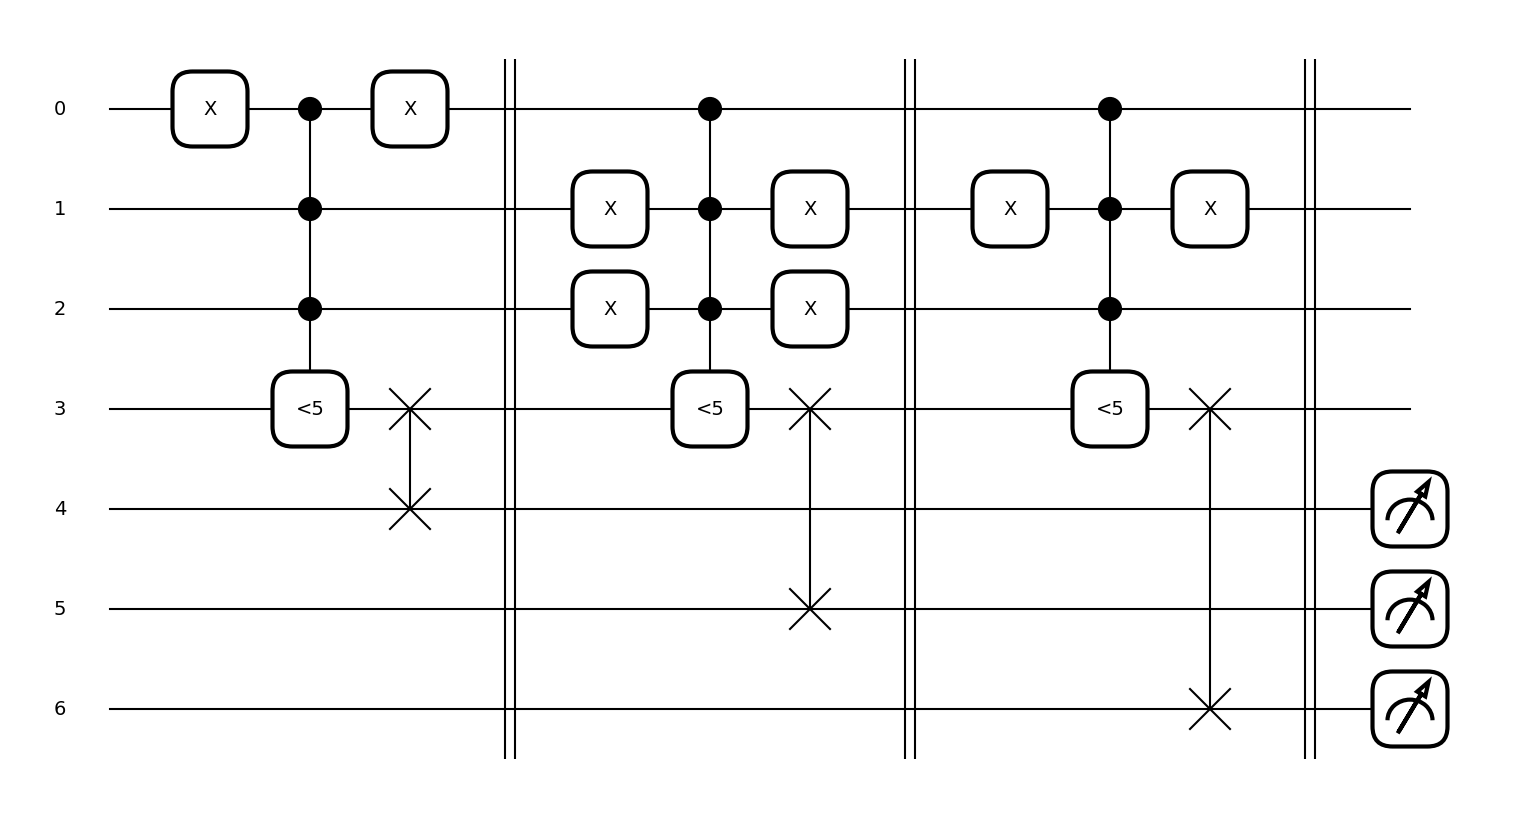

In [4]:
# Show the circuit
qml.draw_mpl(circuit([[1, 0, 0], [0, 1, 1], [0, 1, 0]], 3))(5);

# Helpers

Here some helper functions needed by the `less_than_k` function.

In [5]:
def int2bin(i: int) -> list[bool]:
  """
  Returns the bits array represents the integer `i`.
  """
  return [int(c) for c in list(bin(i)[2:])]

In [6]:
def bin2int(bs: list[int]) -> int:
  """
  Returns the positive integer represents the bits array `bs`.
  """
  r: int = 0
  for b_id, b in enumerate(bs[::-1]):
    r += b << b_id
  return r

In [7]:
def mini_batch(l: list[int], size=8) -> list[int]:
  """
  Returns a generator of mini batch of the list of integers converted to
  an array of bits using Little Endian format.

  (Classical thing, like what we do in machine learning)
  """

  for i in range(0, len(l), size):
    chunck = l[i:i+size]
    tmp = []
    max_len = -1
    for c in chunck:
      bits = int2bin(c)
      assert len(bits) <= 23, f"The size of number {c} is more than 23bits"
      tmp.append(bits)
      if len(bits) > max_len:
        max_len = len(bits)

    yield (tmp, max_len)

# The function
This is the main function of the task.

In [8]:
def less_than_k(k, list_n):
  """
  Returns a string representing all the positive integers less than `k`.

  Args
    - k: The fixed positive integer to compare with
    - list_n : List of positive integers
  """

  klen = len(bin(k)[2:])
  elements: list[str] = []
  for m, mlen in mini_batch(list_n):
    wires = max(mlen, klen)
    # Add padding
    padded = np.array([np.pad(a, (wires - len(a), 0)) for a in m], requires_grad=False)
    results = np.array(circuit(padded, wires)(k), dtype=int)
    for e in padded[np.where(results == -1)]:
      elements.append(str(bin2int(e)))

  return ", ".join(elements)

In [9]:
less_than_k(7, [18, 9, 5, 10, 3, 0, 1, 2, 6, 5, 9])

'5, 3, 0, 1, 2, 6, 5'